In [1]:
# from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from datetime import datetime as dt
import itertools

import statsmodels.api as sm
import scipy.stats as sps

pd.options.mode.chained_assignment = None  # default='warn'
%load_ext autoreload
%autoreload 2

In [2]:
from utils_plot import set_plt_settings, plot_Qval
from utils_data import NODES, PATH_DATA, make_analysis_dataset
from utils_battery import get_efficiency

from utils_mdp_mf import get_discrete_states, train_Q, validate_Q
from utils_cv import train_test_split, crossval_Q

set_plt_settings()

In [3]:
PATH_RESULTS = f'{PATH_DATA}results/'
PATH_RESULTS_LOG = f'{PATH_RESULTS}log/'

# 0. Make analytic datasets and set parameters

In [36]:
node_idx = 0
node = NODES[node_idx]
yr_val = 2022
# read in data
df = make_analysis_dataset(nodes=[node])
df = sm.add_constant(df, has_constant='add')
# drop 2022
# df = df.loc[df.year != 2022]

# col params
X_cols = ['month', 'quarter', 'const', 'hour', 'dow']
y_col = 'lmp_rt'
group_cols = ['year']

In [227]:
# set hypterparameters
hp_Q = {'pct_c':0.5, 'alpha':0.1, 'gamma':0.95, 
        'eps': 0.99, 'eps_dec': 0.1, 'm':100}
hp_R = {'alpha':0.5, 'pct_rev':0.25, 'pct_ma':0.75}

In [228]:
# set battery params
b_params = {'dur':4, 'capacity':200}
b_params['efficiency'] = get_efficiency(b_params['dur'])

In [229]:
# take out holdout data
X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, X_cols, y_col, group_cols, yr_val=2022)

In [235]:
# discretize space
s_e, s_t, s_h, s_dow, (s_rt, rt_q) = get_discrete_states(X_tt, y_tt, b_params, None, tcol='const', m=hp_Q['m'])
s_ev, s_tv, s_hv, s_dowv, (s_rtv, __) = get_discrete_states(X_val, y_val, b_params, rt_q, tcol='const', m=hp_Q['m'])

# 2. Q-learn

In [236]:
states = s_e, s_t, s_h, s_dow, s_rt
Q, Q_log, eps_log = train_Q(states, y_tt, b_params, hp_Q, hp_R, 100, 10000, True)

100%|█████████████████████████████████████████| 100/100 [00:25<00:00,  4.00it/s]


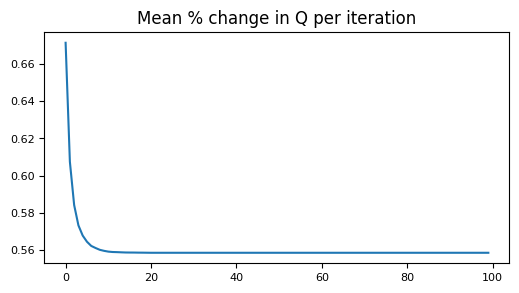

In [237]:
# look at Q convergence
plt.figure(figsize=(6, 3))
plt.plot(Q_log)
plt.title('Mean % change in Q per iteration')
plt.show()

100%|██████████████████████████████████| 70072/70072 [00:01<00:00, 35762.99it/s]


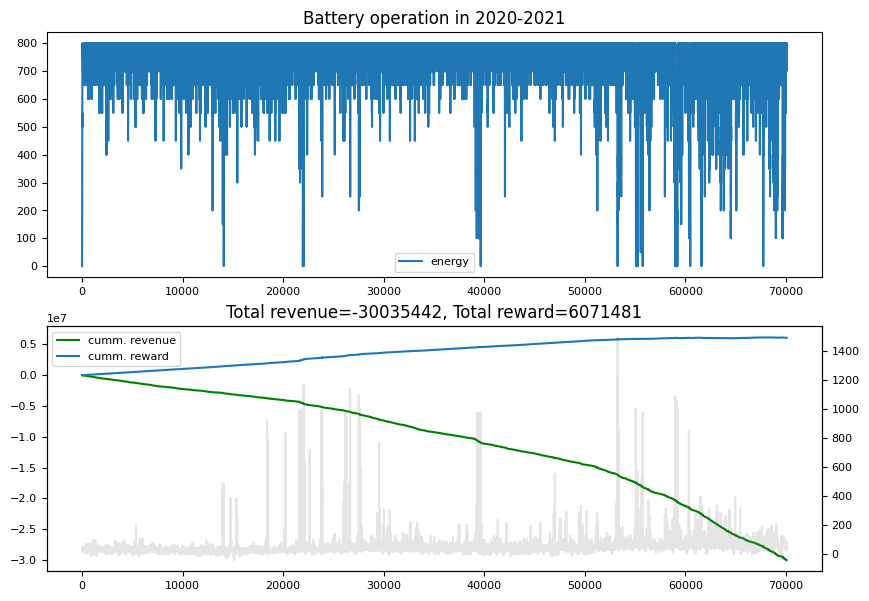

In [238]:
states = s_e, s_t, s_h, s_dow, s_rt
ace, revrew = validate_Q(Q, states, y_tt, b_params, hp_R, True)
plot_Qval(ace, revrew, y_tt, b_params, yr='2020-2021')

100%|██████████████████████████████████| 35035/35035 [00:00<00:00, 35352.79it/s]


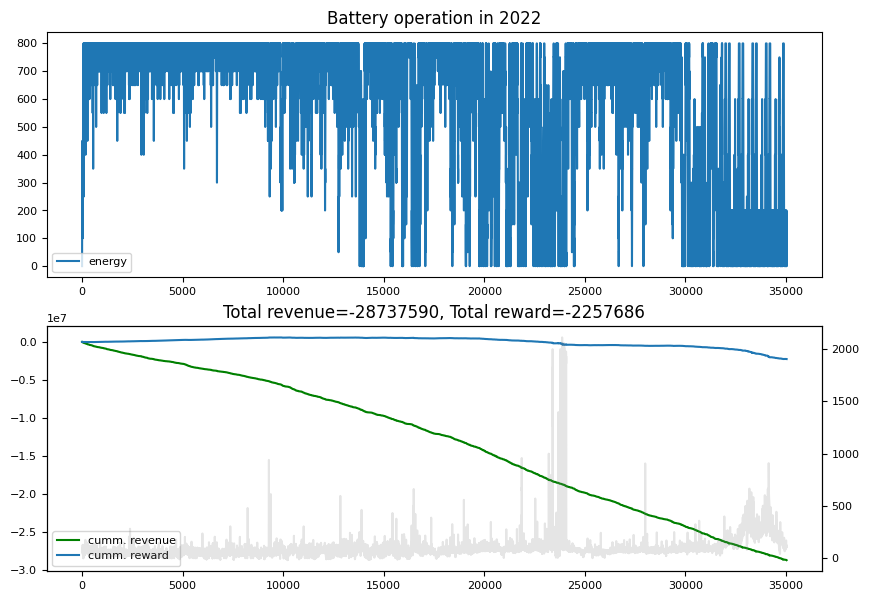

In [239]:
states = s_e, s_tv, s_hv, s_dowv, s_rtv
ace, revrew = validate_Q(Q, states, y_val, b_params, hp_R, True)
plot_Qval(ace, revrew, y_val, b_params, yr=yr_val)

# 3. Train with optimal hyperparameters

In [14]:
dur = 4

In [23]:
# set battery params
b_params = {'dur':dur, 'capacity':200}
b_params['efficiency'] = get_efficiency(b_params['dur'])

# take out holdout data
X_tt, y_tt, g_tt, X_val, y_val = train_test_split(df, X_cols, y_col, group_cols, yr_val=2022)

# discretize space
s_e, s_t, s_h, s_dow, (s_rt, rt_q) = get_discrete_states(X_tt, y_tt, b_params, None, hp_Q['m'])
s_ev, s_tv, s_hv, s_dowv, (s_rtv, __) = get_discrete_states(X_val, y_val, b_params, rt_q, hp_Q['m'])

# get best hyperparameters
summ = pd.read_csv(f'{PATH_RESULTS}gsQ_summ_N{NODES[node_idx].lower()}_D{b_params["dur"]}.csv')
summmean = summ.groupby(['alpha', 'epsilon', 'pct_rev', 'pct_ma']).mean().reset_index()

# store best
# summmean['abs_rev_m_rew'] = np.abs(summmean.cumrev - summmean.cumrew)
# closest revenue performance to reward, conditional on being in 75th pctl. revenue
# opt_idx = summmean.loc[summmean.cumrev >= summmean.cumrev.quantile(0.9)].abs_rev_m_rew.argmin()
opt_idx = summmean.cumrev.argmin()
hp_optimal = summmean.iloc[opt_idx].values[:4]

hp_optimal = [0.1, 0.99, 0.5, 0.75]
print('best params:', hp_optimal, f'(mean cumrev={summmean.cumrev.max()})')

# update parameters
hp_Q['alpha'] = hp_optimal[0]
hp_Q['eps'] = hp_optimal[1]
hp_R['pct_rev'] = hp_optimal[2]
hp_R['pct_ma'] = hp_optimal[3]

best params: [0.1, 0.99, 0.5, 0.75] (mean cumrev=1589317.837837839)


In [24]:
# train Q on whole training dataset
t = int(len(s_t)/2)
states = s_e, s_t[t:], s_h[t:], s_dow[t:], s_rt[t:]
Q, Q_log, eps_log = train_Q(states, y_tt[t:], b_params, hp_Q, hp_R, verbose=True)

100%|███████████████████████████████████████████| 25/25 [00:47<00:00,  1.91s/it]


100%|██████████████████████████████████| 70072/70072 [00:01<00:00, 39780.16it/s]


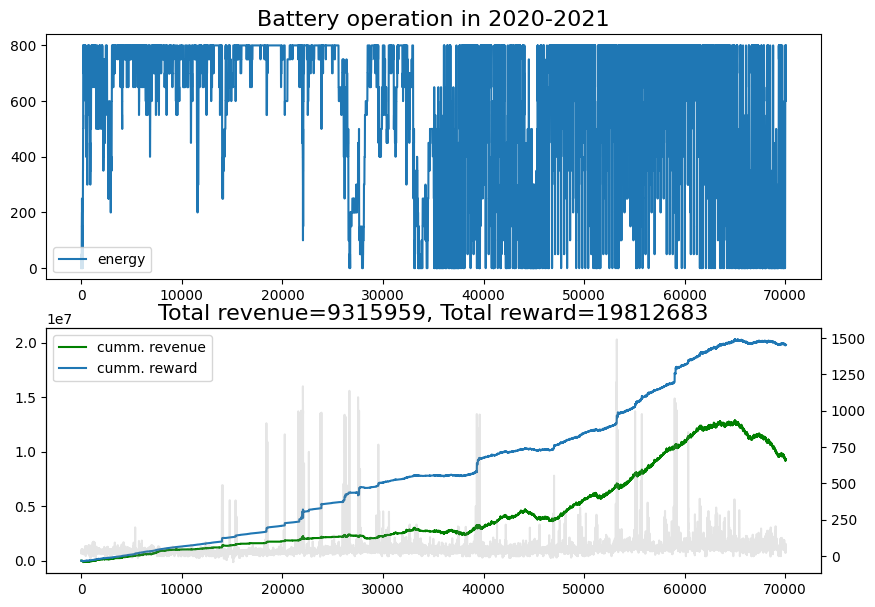

In [25]:
# validate on training data
states = s_e, s_t, s_h, s_dow, s_rt
ace, revrew = validate_Q(Q, states, y_tt, b_params, hp_R, True)
plot_Qval(ace, revrew, y_tt, b_params, '2020-2021')

100%|██████████████████████████████████| 35035/35035 [00:00<00:00, 40262.25it/s]


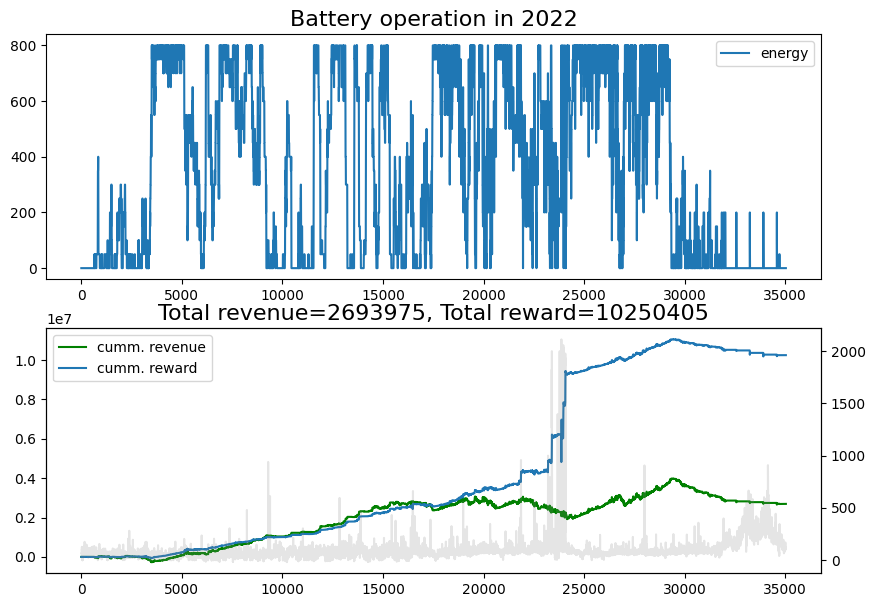

In [26]:
# validate on validation data
states = s_e, s_tv, s_hv, s_dowv, s_rtv
ace, revrew = validate_Q(Q, states, y_val, b_params, hp_R, True)
plot_Qval(ace, revrew, y_val, b_params, yr_val)

# Read and write Q

In [72]:
# save files
Qshape = Q.shape
Qflat = Q.flatten()

np.savetxt(f'{PATH_RESULTS}gsQ_Qflat_N{NODES[node_idx].lower()}_D{b_params["dur"]}.csv', Qflat, delimiter=",")
np.savetxt(f'{PATH_RESULTS}gsQ_Qshape_N{NODES[node_idx].lower()}_D{b_params["dur"]}.csv', Qshape, delimiter=",")

In [73]:
# read in Q
Qflat = np.loadtxt(f'{PATH_RESULTS}gsQ_Qflat_N{NODES[node_idx].lower()}_D{b_params["dur"]}.csv')
Qshape = np.loadtxt(f'{PATH_RESULTS}gsQ_Qshape_N{NODES[node_idx].lower()}_D{b_params["dur"]}.csv').astype(int)
Qin = Qflat.reshape(Qshape)